# K factor analysis

In transportation planning, the percentage of AADT that occurs during the peak is referred to as the K factor, and the standard for planning analyses is 9%. Relatedly, the D factor is the directional distribution, standard is 55%.

In [74]:
using CSV
using Parquet
using DataFrames
using Plots
using Dates
using CategoricalArrays
using Missings
using Random
using Statistics
using StatsBase

In [2]:
# federal holidays, observed
# https://www.opm.gov/policy-data-oversight/pay-leave/federal-holidays/#url=2021
const HOLIDAYS = Set([
    Date(2016, 1, 1),
    Date(2016, 1, 18),
    Date(2016, 2, 15),
    Date(2016, 5, 30),
    Date(2016, 7, 4),
    Date(2016, 9, 5),
    Date(2016, 10, 10),
    Date(2016, 11, 11),
    Date(2016, 11, 24),
    Date(2016, 12, 26),
    
    Date(2017, 1, 2),
    Date(2017, 1, 16),
    Date(2017, 2, 20),
    Date(2017, 5, 29),
    Date(2017, 7, 4),
    Date(2017, 9, 4),
    Date(2017, 10, 9),
    Date(2017, 11, 10),
    Date(2017, 11, 23),
    Date(2017, 12, 25),
    
    Date(2018, 1, 1),
    Date(2018, 1, 15),
    Date(2018, 2, 19),
    Date(2018, 5, 28),
    Date(2018, 7, 4),
    Date(2018, 9, 3),
    Date(2018, 10, 8),
    Date(2018, 11, 12),
    Date(2018, 11, 22),
    Date(2018, 12, 25),
    
    Date(2019, 1, 1),
    Date(2019, 1, 21),
    Date(2019, 2, 18),
    Date(2019, 5, 27),
    Date(2019, 7, 4),
    Date(2019, 9, 2),
    Date(2019, 10, 14),
    Date(2019, 11, 11),
    Date(2019, 11, 28),
    Date(2019, 12, 25),
        
    Date(2020, 1, 1),
    Date(2020, 1, 20),
    Date(2020, 2, 17),
    Date(2020, 5, 25),
    Date(2020, 7, 3),
    Date(2020, 9, 7),
    Date(2020, 10, 12),
    Date(2020, 11, 26),
    Date(2020, 12, 25),
        
    Date(2021, 1, 1),
    Date(2021, 1, 18),
    # not including inauguration day, not a holiday in CA
    Date(2021, 2, 15),
    Date(2021, 5, 31),
    Date(2021, 6, 18),
    Date(2021, 7, 5),
    Date(2021, 9, 6),
    Date(2021, 10, 11),
    Date(2021, 11, 11),
    Date(2021, 11, 25),
    Date(2021, 12, 24)
])

# all holidays and the days before and after
const HOLIDAYS_Δ1 = Set([
        HOLIDAYS...,
        (HOLIDAYS .+ Dates.Day(1))...,
        (HOLIDAYS .- Dates.Day(1))...
])
        


Set{Date} with 180 elements:
  Date("2016-09-05")
  Date("2021-09-07")
  Date("2018-07-04")
  Date("2021-12-25")
  Date("2021-07-04")
  Date("2020-02-16")
  Date("2017-02-21")
  Date("2017-01-02")
  Date("2018-01-14")
  Date("2020-01-20")
  Date("2018-01-02")
  Date("2017-07-04")
  Date("2017-05-30")
  Date("2017-07-03")
  Date("2019-11-27")
  Date("2016-07-04")
  Date("2016-12-25")
  Date("2020-07-04")
  Date("2020-02-17")
  Date("2017-01-16")
  Date("2019-12-25")
  Date("2019-12-26")
  Date("2017-11-10")
  Date("2021-01-19")
  Date("2018-11-12")
  ⋮ 

In [3]:
data = DataFrame(read_parquet("../data/d04_peaks.parquet"))

7685237×13 DataFrame
     Row │ station  peak_hour_occ    total_occ     total_flow  station_type  f ⋯
         │ Int64?   Float64?         Float64?      Int64?      String?       I ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │  400000        0.0984209        6.7191       37379  ML              ⋯
       2 │  400001        0.0762086        6.5032       43831  ML
       3 │  400002        0.0697402       12.5265       87695  ML
       4 │  400006        0.0772156       12.5959       74577  ML
       5 │  400007        0.080149        13.6633       93394  ML              ⋯
       6 │  400009        0.0927226       13.3193      102566  ML
       7 │  400010        0.0810354        9.2836       53010  ML
       8 │  400011        0.0935766        9.0995       51277  ML
       9 │  400014        0.077238         6.6677       48923  ML              ⋯
      10 │  400015        0.086172         2.8652       14747  ML
      11 │  400017        0.0778472        7.6496       43019  ML
    ⋮    │    ⋮            ⋮              ⋮            ⋮            ⋮          ⋱
 7685228 │  426309        0.12152          1.3685         911  OR
 7685229 │  426311        0.178799        15.0627       65822  ML              ⋯
 7685230 │  426312  missing          missing          missing  OR
 7685231 │  426313        0.248989        12.072        56677  ML
 7685232 │  426314        0.113411         3.4926       11168  OR
 7685233 │  426315        0.190504        13.8522       62989  ML              ⋯
 7685234 │  426316  missing          missing          missing  FR
 7685235 │  426317  missing          missing          missing  OR
 7685236 │  426318  missing          missing          missing  OR
 7685237 │  426340        0.125654        21.5767      106100  ML              ⋯
                                              8 columns and 7685216 rows omitted

In [4]:
data.date = Date.(data.year, data.month, data.day)

7685237-element Vector{Date}:
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 2016-01-01
 ⋮
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12
 2021-08-12

In [50]:
# dates where there was no mask mandate in California
# statewide mask mandate lifted June 15: https://www.latimes.com/science/story/2021-07-27/timeline-cdc-mask-guidance-during-covid-19-pandemic
# LA county requires masks again after July 17: https://www.latimes.com/california/story/2021-07-15/l-a-county-will-require-masks-indoors-amid-covid-19-surge
period = [Date(2021, 6, 15), Date(2021, 7, 17)]

periods = Dict(
    "postpandemic" => [period],
    "pandemic" => [period .- Dates.Year(1)],
    "prepandemic" => [
        period .- Dates.Year(2),
        period .- Dates.Year(3),
        period .- Dates.Year(4),
        period .- Dates.Year(5)
    ]
)

function period_for_date(date)
    for (name, dates) in periods
        for range in dates
            if date >= range[1] && date <= range[2]
                return name
            end
        end
    end
    return missing
end

data.period = CategoricalArray(period_for_date.(data.date))

289563-element CategoricalArray{String,1,UInt32}:
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 "prepandemic"
 ⋮
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"
 "postpandemic"

In [51]:
# how many observations in each period?
combine(groupby(data, :period), nrow)

3×2 DataFrame
 Row │ period        nrow   
     │ Cat…          Int64  
─────┼──────────────────────
   1 │ pandemic       51678
   2 │ postpandemic   48539
   3 │ prepandemic   189346

In [7]:
data.dayofweek = CategoricalArray(Dates.dayname.(data.date))

7685237-element CategoricalArray{String,1,UInt32}:
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 "Friday"
 ⋮
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"
 "Thursday"

In [53]:
# filter to just mainline (i.e. not onramps etc)
data = data[
    # filter to weekdays
    in.(data.dayofweek, [Set(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]) .&
    # that are in one of the defined periods
    .!ismissing.(data.period) .&
    # not missing occupancy data
    .!isnan.(data.peak_hour_occ) .&
    # are not holidays or adjacent
    .!in.(data.date, [HOLIDAYS_Δ1]) .&
    # and are mainline observations, i.e. not onramps etc
    (data.station_type .== "ML"), :]

289563×12 DataFrame
    Row │ station  peak_hour_occ  total_occ  total_flow  station_type  freeway ⋯
        │ Int64?   Float64?       Float64?   Int64?      String?       Int64?  ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │  400000      0.214265     13.8805       63367  ML                    ⋯
      2 │  400001      0.159621     15.6621       75044  ML
      3 │  400002      0.109298     23.8916      119674  ML
      4 │  400006      0.124164     25.7966      106115  ML
      5 │  400007      0.113945     25.924       140209  ML                    ⋯
      6 │  400009      0.101116     37.6351      112960  ML
      7 │  400010      0.073623     17.6222       90431  ML
      8 │  400011      0.160574     17.2288       78148  ML
      9 │  400014      0.0816167     9.4564       68201  ML                    ⋯
     10 │  400015      0.214596     10.7136       40973  ML
     11 │  400017      0.177898     21.6916       65951  ML
   ⋮    │    ⋮           ⋮            ⋮          ⋮            ⋮              ⋮ ⋱
 289554 │  425940      0.105128     12.4971       96268  ML
 289555 │  426295      0.240768     10.9159       60885  ML                    ⋯
 289556 │  426298      0.242229     14.7121       54904  ML
 289557 │  426301      0.220859     15.2722       50976  ML
 289558 │  426306      0.102593      7.8777       50374  ML
 289559 │  426308      0.104976      9.365        51459  ML                    ⋯
 289560 │  426311      0.158944     18.7733       69452  ML
 289561 │  426313      0.188546     18.805        63691  ML
 289562 │  426315      0.173714     17.9974       65070  ML
 289563 │  426340      0.239186      3.2711       13098  ML                    ⋯
                                               7 columns and 289542 rows omitted

In [54]:
# work around not being able to store date objects in Parquet from Julia
data.peak_hour_start = passmissing(Time).(data.peak_hour_start_hour, data.peak_hour_start_minute)
# drop columns no longer needed
select!(data, Not([:year, :month, :day, :peak_hour_start_hour, :peak_hour_start_minute]))

LoadError: ArgumentError: column name :peak_hour_start_hour not found in the data frame

# Overall congestion

In [38]:
# https://identity.unc.edu/brand/color-palette/
const UNC_BLUE = RGB(75/255, 156/255, 211/255)
const UNC_NAVY = RGB(19/255, 41/255, 75/255)
const UNC_DAVIE_GREEN = RGB(196/255, 214/255, 0/255)
const UNC_PINK = RGB(239/255, 68/255, 111/255)

In [25]:
RGB(

RGBA

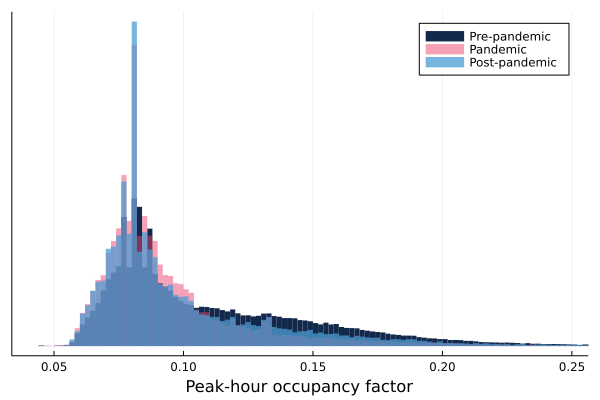

In [143]:
histogram(data.peak_hour_occ[data.period .== "prepandemic"], xlim=[0.04, 0.25], fillcolor=UNC_NAVY, lw=0, label="Pre-pandemic", normalize=true,
    xlabel="Peak-hour occupancy factor",
    yticks=[]
)
histogram!(data.peak_hour_occ[data.period .== "pandemic"], xlim=[0.04, 0.25], fillcolor=UNC_PINK, lw=0, alpha=0.5, label="Pandemic", normalize=true)
histogram!(data.peak_hour_occ[data.period .== "postpandemic"], xlim=[0.04, 0.25], fillcolor=UNC_BLUE, lw=0, alpha=0.75, label="Post-pandemic", normalize=true)

In [157]:
function cumulative_dist(v)
    sorted = sort(v[isfinite.(v)])
    return sorted, (1:length(sorted)) ./ length(sorted)
end

function cumulative_dist(v, w)
    f = isfinite.(v) .& isfinite.(w)
    v = v[f]
    w = w[f]
    sorter = sortperm(v)
    sorted = v[sorter]
    return sorted, cumsum(w[sorter]) / sum(w)
end

cumulative_dist (generic function with 2 methods)

In [158]:
prex, prey = cumulative_dist(data.peak_hour_occ[data.period .== "prepandemic"], data.total_flow[data.period .== "prepandemic"])
durx, dury = cumulative_dist(data.peak_hour_occ[data.period .== "pandemic"], data.total_flow[data.period .== "pandemic"])
postx, posty = cumulative_dist(data.peak_hour_occ[data.period .== "postpandemic"], data.total_flow[data.period .== "postpandemic"])

plot(prex, prey, linecolor=UNC_NAVY, label="Pre-pandemic", xlim=[1/24, 0.25])
plot!(durx, dury, linecolor=UNC_PINK, label="Pandemic")
plot!(postx, posty, linecolor=UNC_BLUE, label="Post-pandemic")

In [159]:
v = [2, 3, 2, 5, 1, 7]
r = StatsBase.ordinalrank(v)
τ = collect(1:length(v))[r]
σ = zeros(eltype(v), length(v))
σ[r] = v
σ

6-element Vector{Int64}:
 1
 2
 2
 3
 5
 7

In [156]:
?sortperm

search: sortperm sortperm! partialsortperm partialsortperm! isconcretetype



```
sortperm(v; alg::Algorithm=DEFAULT_UNSTABLE, lt=isless, by=identity, rev::Bool=false, order::Ordering=Forward)
```

Return a permutation vector `I` that puts `v[I]` in sorted order. The order is specified using the same keywords as [`sort!`](@ref). The permutation is guaranteed to be stable even if the sorting algorithm is unstable, meaning that indices of equal elements appear in ascending order.

See also [`sortperm!`](@ref).

# Examples

```jldoctest
julia> v = [3, 1, 2];

julia> p = sortperm(v)
3-element Vector{Int64}:
 2
 3
 1

julia> v[p]
3-element Vector{Int64}:
 1
 2
 3
```

---

```
sortperm(df::AbstractDataFrame, cols;
         alg::Union{Algorithm, Nothing}=nothing, lt=isless, by=identity,
         rev::Bool=false, order::Ordering=Forward)
```

Return a permutation vector of row indices of data frame `df` that puts them in sorted order according to column(s) `cols`.

`cols` can be any column selector (`Symbol`, string or integer; `:`, `Cols`, `All`, `Between`, `Not`, a regular expression, or a vector of `Symbol`s, strings or integers).

If `alg` is `nothing` (the default), the most appropriate algorithm is chosen automatically among `TimSort`, `MergeSort` and `RadixSort` depending on the type of the sorting columns and on the number of rows in `df`. If `rev` is `true`, reverse sorting is performed. To enable reverse sorting only for some columns, pass `order(c, rev=true)` in `cols`, with `c` the corresponding column index (see example below). See other methods for a description of other keyword arguments.

# Examples

```jldoctest
julia> df = DataFrame(x = [3, 1, 2, 1], y = ["b", "c", "a", "b"])
4×2 DataFrame
 Row │ x      y
     │ Int64  String
─────┼───────────────
   1 │     3  b
   2 │     1  c
   3 │     2  a
   4 │     1  b

julia> sortperm(df, :x)
4-element Vector{Int64}:
 2
 4
 3
 1

julia> sortperm(df, [:x, :y])
4-element Vector{Int64}:
 4
 2
 3
 1

julia> sortperm(df, [:x, :y], rev=true)
4-element Vector{Int64}:
 1
 3
 2
 4

julia> sortperm(df, [:x, order(:y, rev=true)])
4-element Vector{Int64}:
 2
 4
 3
 1
```


- June 15, 2016
- June 20, 2017
- June 14, 2018
- June 16, 2019
- June 17, 2021

In [91]:
d2 = data[(data.period .!= "pandemic") .& (.!isnan.(data.peak_hour_occ)), :]

237781×12 DataFrame
    Row │ station  peak_hour_occ  total_occ  total_flow  station_type  freeway ⋯
        │ Int64?   Float64?       Float64?   Int64?      String?       Int64?  ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │  400000      0.214265     13.8805       63367  ML                    ⋯
      2 │  400001      0.159621     15.6621       75044  ML
      3 │  400002      0.109298     23.8916      119674  ML
      4 │  400006      0.124164     25.7966      106115  ML
      5 │  400007      0.113945     25.924       140209  ML                    ⋯
      6 │  400009      0.101116     37.6351      112960  ML
      7 │  400010      0.073623     17.6222       90431  ML
      8 │  400011      0.160574     17.2288       78148  ML
      9 │  400014      0.0816167     9.4564       68201  ML                    ⋯
     10 │  400015      0.214596     10.7136       40973  ML
     11 │  400017      0.177898     21.6916       65951  ML
   ⋮    │    ⋮           ⋮            ⋮          ⋮            ⋮              ⋮ ⋱
 237772 │  425940      0.105128     12.4971       96268  ML
 237773 │  426295      0.240768     10.9159       60885  ML                    ⋯
 237774 │  426298      0.242229     14.7121       54904  ML
 237775 │  426301      0.220859     15.2722       50976  ML
 237776 │  426306      0.102593      7.8777       50374  ML
 237777 │  426308      0.104976      9.365        51459  ML                    ⋯
 237778 │  426311      0.158944     18.7733       69452  ML
 237779 │  426313      0.188546     18.805        63691  ML
 237780 │  426315      0.173714     17.9974       65070  ML
 237781 │  426340      0.239186      3.2711       13098  ML                    ⋯
                                               7 columns and 237760 rows omitted

In [65]:
# first just shuffle dates


124×2 DataFrame
 Row │ date        period       
     │ Date        Cat…         
─────┼──────────────────────────
   1 │ 2016-06-15  prepandemic
   2 │ 2016-06-16  prepandemic
   3 │ 2016-06-17  prepandemic
   4 │ 2016-06-20  prepandemic
   5 │ 2016-06-21  prepandemic
   6 │ 2016-06-22  prepandemic
   7 │ 2016-06-23  prepandemic
   8 │ 2016-06-24  prepandemic
   9 │ 2016-06-27  prepandemic
  10 │ 2016-06-28  prepandemic
  11 │ 2016-06-29  prepandemic
  ⋮  │     ⋮            ⋮
 115 │ 2021-07-01  postpandemic
 116 │ 2021-07-02  postpandemic
 117 │ 2021-07-07  postpandemic
 118 │ 2021-07-08  postpandemic
 119 │ 2021-07-09  postpandemic
 120 │ 2021-07-12  postpandemic
 121 │ 2021-07-13  postpandemic
 122 │ 2021-07-14  postpandemic
 123 │ 2021-07-15  postpandemic
 124 │ 2021-07-16  postpandemic
                103 rows omitted

In [109]:
function permute(data, n_permutations)
    output = zeros(Float64, (2, n_permutations))
    dates_and_periods = combine(groupby(data, :date), :period => first => :period)
    
    rng = MersenneTwister(8675309)
    
    period_map = Dict()
    sizehint!(period_map, nrow(dates_and_periods))
    
    for permutation in 1:n_permutations
        shuffle!(rng, dates_and_periods.period)

        for i in 1:nrow(dates_and_periods)
            period_map[dates_and_periods[i, :date]] = dates_and_periods[i, :period]
        end

        data.permuted_period = map(d -> period_map[d], data.date)

        means = combine(groupby(data, :permuted_period), :peak_hour_occ => mean => :mean_peak_occ)

        @assert nrow(means) == 2

        output[1, permutation] = means[means.permuted_period .== "prepandemic", :mean_peak_occ][1]
        output[2, permutation] = means[means.permuted_period .== "postpandemic", :mean_peak_occ][1]
    end
    
    return output
end

permute (generic function with 1 method)

In [110]:
@time means = permute(d2, 1000)

 39.762258 seconds (59.28 M allocations: 3.583 GiB, 4.53% gc time, 2.52% compilation time)


2×1000 Matrix{Float64}:
 0.110191  0.109869  0.109703  0.109447  …  0.110073  0.110278  0.109948
 0.108538  0.109898  0.110557  0.11157      0.10908   0.108171  0.109574

In [111]:
diff_means = means[1, :] .- means[2, :]

1000-element Vector{Float64}:
  0.001652528980104373
 -2.9052595055228947e-5
 -0.0008540936869897292
 -0.0021230839292868536
  0.0013763561438836086
 -0.0017582315779623853
 -0.0013400997674235526
  0.000527315903020617
  0.0010616080057643251
 -0.0007118783549185381
  0.002465977532263519
  0.0009617044539817904
 -0.0010219856439837166
  ⋮
 -1.553929270813048e-5
 -0.0010070425157928803
 -0.00255856766204271
 -0.0032608267226159338
  0.0014480113982564408
  0.002775152685486379
 -0.0017117632790844967
 -0.00077643843268764
  0.000124211027411128
  0.0009936003458888287
  0.0021077459187670566
  0.000373603628772215

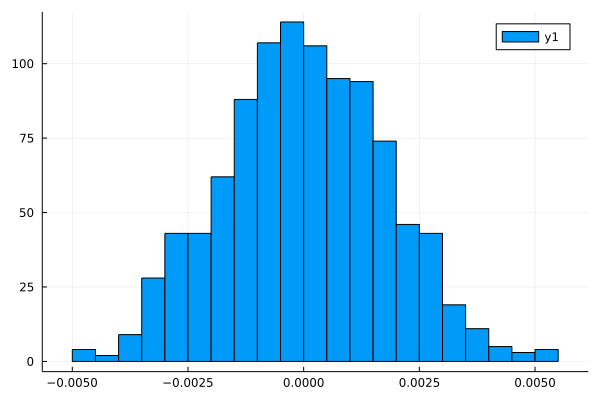

In [112]:
histogram(diff_means)

In [114]:
obs_means = combine(groupby(d2, :period), :peak_hour_occ => mean)

2×2 DataFrame
 Row │ period        peak_hour_occ_mean 
     │ Cat…          Float64            
─────┼──────────────────────────────────
   1 │ postpandemic           0.0999886
   2 │ prepandemic            0.11241

In [115]:
obs_diff = obs_means[obs_means.period .== "postpandemic", :peak_hour_occ_mean][1] - obs_means[obs_means.period .== "prepandemic", :peak_hour_occ_mean][1]

-0.012420954834995473

In [89]:
sum(isnan.(data.peak_hour_occ))

118

#

In [60]:
# there are way too many of some values - probably due to imputation
# robustness checks (TODO):
# - remove imputed data
# - check if imputation frequency changed pre-post pandemic
sort(combine(groupby(data, :peak_hour_occ), nrow), :nrow, rev=true)

256500×2 DataFrame
    Row │ peak_hour_occ  nrow  
        │ Float64?       Int64 
────────┼──────────────────────
      1 │     0.086381    2802
      2 │     0.0817829   2690
      3 │     0.0816834   2615
      4 │     0.0827498   2479
      5 │     0.07733     2399
      6 │     0.0811466   2206
      7 │     0.0810205   2139
      8 │     0.0808607   2138
      9 │     0.0768787   2130
     10 │     0.0821211   1909
     11 │     0.0863275    777
   ⋮    │       ⋮          ⋮
 256491 │     0.105128       1
 256492 │     0.240768       1
 256493 │     0.242229       1
 256494 │     0.220859       1
 256495 │     0.102593       1
 256496 │     0.104976       1
 256497 │     0.158944       1
 256498 │     0.188546       1
 256499 │     0.173714       1
 256500 │     0.239186       1
            256479 rows omitted

## Disaggregation

- Urban/rural
- Speed limit
- Overall congestion

In [134]:
k_factor_by_sensor = combine(groupby(data, [:period, :station]), :peak_hour_occ => mean => :peak_hour_occ)

7331×3 DataFrame
  Row │ period       station  peak_hour_occ 
      │ Cat…         Int64?   Float64       
──────┼─────────────────────────────────────
    1 │ pandemic      400000      0.0760419
    2 │ pandemic      400001      0.113548
    3 │ pandemic      400002      0.0888627
    4 │ pandemic      400006      0.081153
    5 │ pandemic      400007      0.0788097
    6 │ pandemic      400009      0.13302
    7 │ pandemic      400010      0.0809229
    8 │ pandemic      400011      0.0819959
    9 │ pandemic      400014      0.100145
   10 │ pandemic      400017      0.128358
   11 │ pandemic      400025      0.175519
  ⋮   │      ⋮          ⋮           ⋮
 7322 │ prepandemic   424045      0.223168
 7323 │ prepandemic   424047      0.154766
 7324 │ prepandemic   424051      0.134489
 7325 │ prepandemic   424055      0.101932
 7326 │ prepandemic   424059      0.176402
 7327 │ prepandemic   424075      0.110295
 7328 │ prepandemic   424077      0.10516
 7329 │ prepandemic   424082      0.0985437
 7330 │ prepandemic   424084      0.107295
 7331 │ prepandemic   424086      0.0788509
                           7310 rows omitted

In [138]:
k_factor_by_sensor = unstack(k_factor_by_sensor, :station, :period, :peak_hour_occ)

2533×4 DataFrame
  Row │ station  pandemic         postpandemic     prepandemic 
      │ Int64?   Float64?         Float64?         Float64?    
──────┼────────────────────────────────────────────────────────
    1 │  400000        0.0760419        0.0846484    0.129437
    2 │  400001        0.113548         0.0929302    0.146699
    3 │  400002        0.0888627        0.0830857    0.103421
    4 │  400006        0.081153         0.0984331    0.123254
    5 │  400007        0.0788097        0.0834697    0.0902581
    6 │  400009        0.13302          0.102113     0.11018
    7 │  400010        0.0809229        0.0671866    0.120362
    8 │  400011        0.0819959        0.102948     0.132042
    9 │  400014        0.100145         0.0770868    0.0866032
   10 │  400017        0.128358         0.155906     0.179686
   11 │  400025        0.175519         0.155042     0.144842
  ⋮   │    ⋮            ⋮                ⋮              ⋮
 2524 │  411115  missing          missing            0.0771178
 2525 │  411117  missing          missing            0.0726932
 2526 │  411133  missing          missing            0.0773355
 2527 │  411138  missing          missing            0.0738381
 2528 │  411139  missing          missing            0.0749021
 2529 │  411142  missing          missing            0.101273
 2530 │  411143  missing          missing            0.0920279
 2531 │  411144  missing          missing            0.0949016
 2532 │  411145  missing          missing            0.0881998
 2533 │  416141  missing          missing            0.164217
                                              2512 rows omitted

In [137]:
# confirm that sensor numbers/locations did not change year-to-year
sensor_meta = CSV.read("../data/d04_text_meta_2021_01_29.tsv", DataFrame, delim="\t")

3929×18 DataFrame
  Row │ ID      Fwy    Dir     District  County  City     State_PM  Abs_PM   L ⋯
      │ Int64   Int64  String  Int64     Int64   Int64?   String    Float64  F ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 400000    101  S              4      41    52582  19.23     459.835    ⋯
    2 │ 400001    101  N              4      85    68000  38.26     387.897
    3 │ 400002    101  S              4      81    68252  14.67     416.893
    4 │ 400006    880  S              4       1    81204  13.54      23.767
    5 │ 400007    101  N              4      81    68252  15.25     417.437    ⋯
    6 │ 400009     80  W              4       1     6000  5.7        11.01
    7 │ 400010    101  N              4      81  missing  20.27     422.457
    8 │ 400011    101  S              4      41    52582  16.15     456.755
    9 │ 400014    101  N              4      85    68000  27.22     376.491    ⋯
   10 │ 400017     85  S              4      85    68000  10.07      10.07
   11 │ 400025    680  N              4      13    83346  13.7       45.192
  ⋮   │   ⋮       ⋮      ⋮        ⋮        ⋮        ⋮        ⋮         ⋮       ⋱
 3920 │ 425326    680  N              4       1  missing  9.37       19.378
 3921 │ 425327    680  N              4       1  missing  9.41       19.418    ⋯
 3922 │ 425396    880  N              4       1    53000  R32.76     42.987
 3923 │ 425545    101  N              4      85    49670  50.36     399.997
 3924 │ 425546    101  N              4      85    49670  50.45     400.087
 3925 │ 425694    101  N              4      85    55282  51.88     401.517    ⋯
 3926 │ 425696    101  N              4      85    55282  52.05     401.687
 3927 │ 425697    101  N              4      85    55282  52.29     401.927
 3928 │ 425699    101  N              4      85    49670  50.16     399.797
 3929 │ 425734    101  S              4      85    55282  52.29     401.963    ⋯
                                                10 columns and 3908 rows omitted

In [140]:
sensor_map = leftjoin(sensor_meta, k_factor_by_sensor, on=:ID => :station)

3929×21 DataFrame
  Row │ ID      Fwy    Dir     District  County  City     State_PM  Abs_PM   L ⋯
      │ Int64   Int64  String  Int64     Int64   Int64?   String    Float64  F ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 400000    101  S              4      41    52582  19.23     459.835    ⋯
    2 │ 400001    101  N              4      85    68000  38.26     387.897
    3 │ 400002    101  S              4      81    68252  14.67     416.893
    4 │ 400006    880  S              4       1    81204  13.54      23.767
    5 │ 400007    101  N              4      81    68252  15.25     417.437    ⋯
    6 │ 400009     80  W              4       1     6000  5.7        11.01
    7 │ 400010    101  N              4      81  missing  20.27     422.457
    8 │ 400011    101  S              4      41    52582  16.15     456.755
    9 │ 400014    101  N              4      85    68000  27.22     376.491    ⋯
   10 │ 400017     85  S              4      85    68000  10.07      10.07
   11 │ 400025    680  N              4      13    83346  13.7       45.192
  ⋮   │   ⋮       ⋮      ⋮        ⋮        ⋮        ⋮        ⋮         ⋮       ⋱
 3920 │ 425245    280  N              4      75    67000  R3.47      53.431
 3921 │ 425246    280  N              4      75    67000  R3.79      53.751    ⋯
 3922 │ 425281    280  S              4      75    67000  R3.46      53.433
 3923 │ 425282    280  S              4      75    67000  R3.79      53.763
 3924 │ 425325    680  N              4       1  missing  9.41       19.418
 3925 │ 425326    680  N              4       1  missing  9.37       19.378    ⋯
 3926 │ 425396    880  N              4       1    53000  R32.76     42.987
 3927 │ 425694    101  N              4      85    55282  51.88     401.517
 3928 │ 425696    101  N              4      85    55282  52.05     401.687
 3929 │ 425699    101  N              4      85    49670  50.16     399.797    ⋯
                                                13 columns and 3908 rows omitted

In [161]:
sensor_map.pre_post = sensor_map.postpandemic - sensor_map.prepandemic

3929-element Vector{Union{Missing, Float64}}:
 -0.044788916052698316
 -0.05376836351289975
 -0.020335735356318912
 -0.024820678977218305
 -0.006788378562513159
 -0.008066858932249829
 -0.05317582554130042
 -0.029094047106996312
 -0.009516471363781434
 -0.02377938724607548
  0.010200523108543497
 -0.023877693648140047
  0.0055299048637759
  ⋮
   missing
   missing
   missing
   missing
   missing
   missing
   missing
   missing
   missing
   missing
   missing
   missing

In [169]:
CSV.write("../data/k_factor_map_d04.csv", dropmissing(sensor_map, [:pre_post, :pandemic]))

"../data/k_factor_map_d04.csv"